In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable
from random import shuffle
from scipy.stats import gamma
import scipy
from scipy.special import gammaln, betaln

%matplotlib inline

mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.figsize'] = (15, 5)

## Generate Poisson data, compare Poisson vs. negBin model

I will generate observed data from a Poisson distribution with a certain lambda. Then I will train a MDN to approximate the posterior over model indices. As models I use a Poisson with Gamma prior and a negative Binomial with Beta prior. 

In [2]:
# set prior parameters 

# gamma prior shape and scale 
shape = 9.
scale = .5

# beta prior shape and scale 
alp = 2. 
bet = 5.
# neg bin number of successes
r = 5.

## Define functions for generating data from the two different models

In [3]:
def generate_poisson(N, shape, scale): 
    
    # sample from prior
    theta = np.random.gamma(shape, scale)
    # generate samples
    x = np.random.poisson(lam=theta, size=N)
    
    return theta, x
    
def calculate_stats(x): 
     return np.sum(x).astype(float)
    
def generate_negbin(N, r, alpha, beta):
    # sample from prior
    theta = np.random.beta(alpha, beta)
    
    # generate samples
    x = np.random.negative_binomial(r, theta, size=N)

    return theta, x

def generate_dataset(n_samples, sample_size): 
    
    X = []
    thetas = []
    m = []

    # for every sample we want a triplet (m_i, theta, sx)
    for i in range(n_samples): 
        
        # sample model index 
        m_i = np.round(np.random.rand()).astype(int)
    
        # generate data from model 
        if m_i == 1: 
            theta, x = generate_negbin(sample_size, r, alp, bet)
        elif m_i == 0: 
            theta, x = generate_poisson(sample_size, shape, scale)
            
        sx = calculate_stats(x)
            
        X.append([sx])
        thetas.append([theta])
        m.append([int(m_i)])
    
    return m, np.array(thetas), np.array(X)

def normalize(X, norm=None):
    if norm is None: 
        xmean = X.mean(axis=0)
        xstd = X.std(axis=0)
    else: 
        xmean = norm[0]
        xstd = norm[1]
    return (X - xmean) / xstd, (xmean, xstd)

## Define separate networks for fitting the prior parameter posterior and the model posterior

In [4]:
def batch_generator(dataset, batch_size=5):
    shuffle(dataset)
    N_full_batches = len(dataset) // batch_size
    for i in range(N_full_batches):
        idx_from = batch_size * i
        idx_to = batch_size * (i + 1)
        xs, ys = zip(*[(x, y) for x, y in dataset[idx_from:idx_to]])
        yield xs, ys

class MDN_psi(nn.Module):
    
    def __init__(self, ndim_input=1, ndim_output=2, n_hidden=5, n_components=1):
        super(MDN_psi, self).__init__()
        self.fc_in = nn.Linear(ndim_input, n_hidden)
        self.tanh = nn.Tanh()
        self.m_out = nn.Linear(n_hidden, ndim_output)

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_m = self.m_out(act)
        return out_m
    
def train_psi(X, Y, model, optim, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]
    
    losses = []

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))            
            y_var = Variable(torch.LongTensor(y_batch)).view(n_minibatch)
            
            (out_act) = model(x_var)
            loss = lossfun(out_act, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            losses.append(loss.data[0])

        if (epoch + 1) % 100 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
    
    return model, optim, losses

## Generate a large data set of triplets (m, theta, sx)

Then separate it into sets for model 1 and model 2 and train the phi networks separately. 

In [5]:
# generate data 
N = 1000
m, theta, X = generate_dataset(1000, N)

# normalize 
X, norm = normalize(X)

# separate it 
mask = np.array(m).squeeze()
theta1, X1, = theta[mask==0], X[mask==0, :]
theta2, X2, = theta[mask==1], X[mask==1, :]

In [6]:
model = MDN_psi(n_hidden=5)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
lossfun = nn.CrossEntropyLoss()

model_psi, optim_psi, losses = train_psi(X, m, model, optim, n_epochs=400, n_minibatch=100)

[epoch 0100] loss: 0.2940
[epoch 0200] loss: 0.3834
[epoch 0300] loss: 0.4133
[epoch 0400] loss: 0.2715


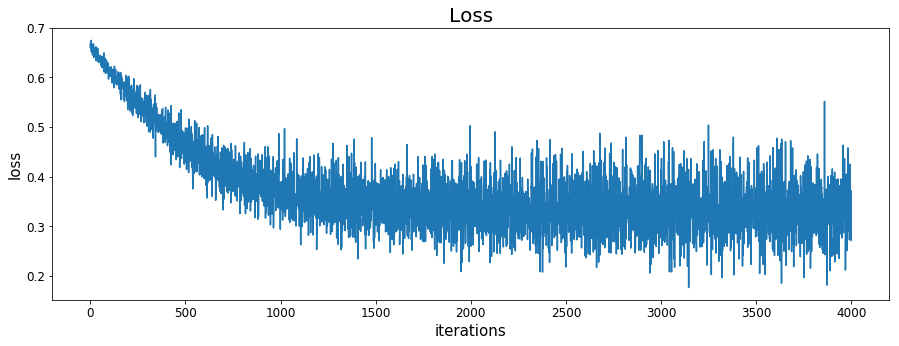

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss');

## Draw many samples and compare predicted to analytical Bayes Factor

In [8]:
def poisson_evidence(x, k, theta, N, log=False): 
    """
    k : shape parameter for gamma 
    theta : scale parameter for gamma
    """
    x_sum = np.sum(x)
    log_xfac = np.sum(gammaln(x + 1))
    
    result = - log_xfac - k * np.log(theta) - gammaln(k) + gammaln(k + x_sum) - (k + x_sum) * np.log(N + 1./theta)
    
    return result if log else np.exp(result)

def nbin_evidence(x, a, b, N, r, log=False): 
    x_sum = np.sum(x)
    
    result = betaln(a + N * r, b + x_sum) - betaln(a, b) + np.sum(np.log(scipy.special.binom(x + r - 1, x)))
    
    return result if log else np.exp(result)

In [9]:
bf_true = []
bf_predicted = []
model_indices = []
pred_mi = []

# gather summary stats
stats = []

true_mean = 1. 
# for poisson the lambda is just the mean 
lam = true_mean
# for negbin the prob of success is related to the mean: 
mu = r / (true_mean + r)

softmax = nn.Softmax()

plot = False
if plot: 
    plt.figure(figsize=(15, 5));

for i in range(100): 
    
    # sample model index 
    m_i = np.round(np.random.rand()).astype(int)
    
    # draw samples from the model given by the model index 
    if m_i == 1: 
        samples = np.random.poisson(lam, N)
    elif m_i == 0: 
        samples = np.random.negative_binomial(r, mu, size=N)
    
    if plot: 
        plt.subplot(1, 2, m_i + 1)
        plt.title('NB' if m_i else 'Poisson')
        plt.hist(samples, bins='auto', alpha=.5)
    
    # apply model for prediction
    stats_o = calculate_stats(samples).reshape(1, 1)
    stats_o, norm = normalize(stats_o, norm)
    
    stats.append(stats_o)
    
    X_var = Variable(torch.Tensor(stats_o))
    (out_act) = model(X_var)
    
    # in this vector, index 0 is Poi, index 1 is NB
    posterior_probs = softmax(out_act).data.numpy()[0]
    # predict the model with the larger posterior 
    pred_mi.append(np.argmax(posterior_probs))
    
    # because we use a uniform prior the posterior ratio corresponds to the likelihood (evidence) ratio
    e0 = poisson_evidence(samples, shape, scale, N, log=True)
    e1 = nbin_evidence(samples, alp, bet, N, r, log=True)

    # calculate bf
    log_bftrue = e0 - e1
    bfpred = posterior_probs[0] / posterior_probs[1]
    
    # append to lists
    bf_predicted.append(np.log(bfpred))
    bf_true.append(log_bftrue)
    model_indices.append(m_i)
    
mi_true = np.array(model_indices)
mi_pred = np.array(pred_mi)
mi_ana = (np.sign(bf_true) + 1) * 0.5
stats = np.array(stats).squeeze()

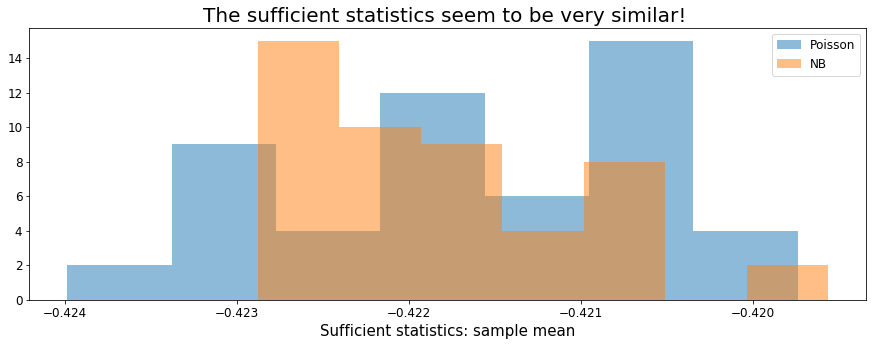

In [10]:
plt.title('The sufficient statistics seem to be very similar! ')
plt.hist(stats[mi_true.astype(int)==0], bins='auto', label='Poisson', alpha=.5)
plt.hist(stats[mi_true.astype(int)==1], bins='auto', label='NB', alpha=.5)
plt.xlabel('Sufficient statistics: sample mean')
plt.legend(); 

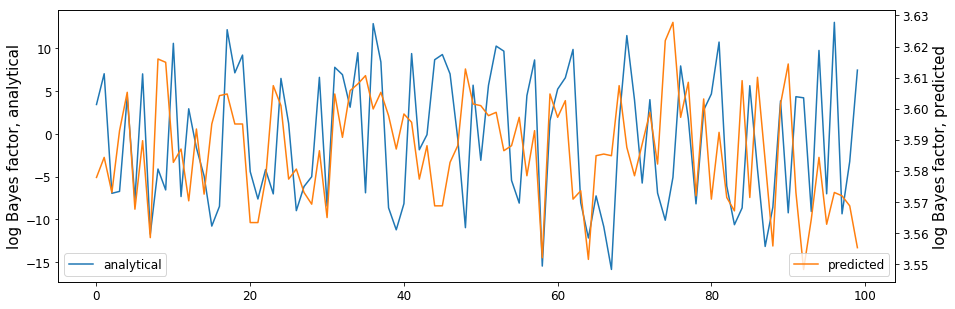

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(bf_true, label='analytical', color='C0')
plt.ylabel('log Bayes factor, analytical')
plt.legend(loc=3)

plt.twinx()
plt.plot(bf_predicted, label='predicted', color='C1')
plt.ylabel('log Bayes factor, predicted')
plt.xlabel('different data sets')

plt.legend(loc=4);

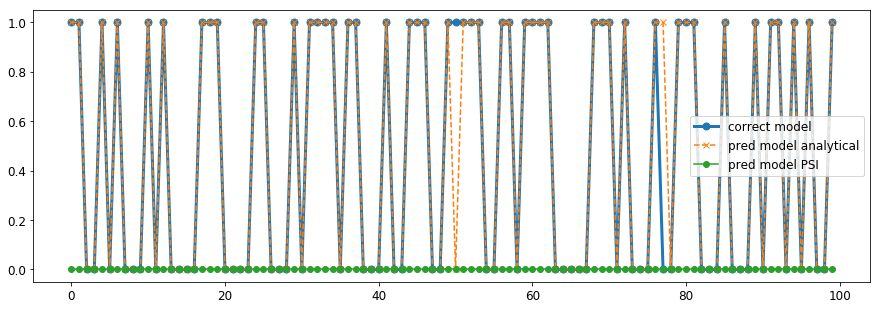

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(mi_true, 'o-', label='correct model', alpha=1., markersize=7, lw=3)
plt.plot(mi_ana, 'x--', label='pred model analytical', alpha=1.)
plt.plot(mi_pred, 'o-', label='pred model PSI')

plt.legend();

In [13]:
np.corrcoef(bf_true, bf_predicted)

array([[ 1.        ,  0.14559939],
       [ 0.14559939,  1.        ]])